In [210]:
import numpy as np
import math
from copy import deepcopy
from typing import List, Callable, Union
import matplotlib.pyplot as plt


In [227]:
def bin_to_float(bitstring: str) -> float:
    if len(bitstring) != 16 or not all(digit in '01' for digit in bitstring):
        raise ValueError("Invalid bitstring length")
    
    int_val = int(bitstring, 2)
    bytes_val = int_val.to_bytes(2, byteorder='big')
    return np.frombuffer(bytes_val, dtype=np.float16)[0]  # Use np.float16
    
print(bin_to_float('0000000000000001'))


1.526e-05


In [228]:
def decode_multidim(chromosome: str, dimensions: int) -> List[float]:
    
    if len(chromosome) % dimensions != 0:
        raise ValueError(f"Chromosome length must be divisible by dimensions ({dimensions})")
    
    bits_per_dim = len(chromosome) // dimensions
    
    if bits_per_dim != 16:
        raise ValueError("Each dimension must use 16 bits")
    
    values = []
    for i in range(dimensions):
        start_idx = i * bits_per_dim
        end_idx = start_idx + bits_per_dim
        dim_bits = chromosome[start_idx:end_idx]
        values.append(bin_to_float(dim_bits))
    
    return values


In [213]:
class Qubit():
    superposition_amplitude = 1 / np.sqrt(2)

    def __init__(self, measurement: bool) -> None:
        self.measurement: bool = measurement
        self.alpha: float = self.superposition_amplitude
        self.beta: float = self.superposition_amplitude
        self.superposition: bool = False
        
    def apply_hadamard(self) -> 'Qubit':
        superposition_amplitude = 1 / np.sqrt(2)

        self.alpha = superposition_amplitude
        self.beta = superposition_amplitude
        self.superposition = True
        
        return self
        
    def apply_xgate(self) -> None:
        self.measurement = not self.measurement
        
    def measure(self) -> bool:
        if not self.superposition:
            return self.measurement
        
        random_var = np.random.uniform(0, 1)
        self.measurement = np.power(self.beta, 2) >= random_var
        self.superposition = False
        
        return self.measurement
    
    def __str__(self) -> str:
        return f'Qubit[superposition: {self.superposition}, [measurement: {self.measurement}]]'


In [214]:
def single_qubit_measurement(qubit: Qubit) -> bool:
    return qubit.measure()

def full_measurement(quantum_chromosome: List[Qubit]) -> str:
    measured_bits = []
    
    for gene in quantum_chromosome:
        measured_value = gene.measure()
        measured_bits.append(str(int(measured_value)))
        
    return ''.join(measured_bits)

def crossover(
        queen: List[Qubit],
        male: List[Qubit],
        num_swap_qubits: int
    ) -> str:

    quantum_chromosome = deepcopy(queen)
    random_ind = np.random.randint(0, len(queen) - num_swap_qubits)
    
    for i in range(random_ind, random_ind + num_swap_qubits):
        if queen[i].measure() == male[i].measure():
            quantum_chromosome[i].apply_hadamard()
        else:
            quantum_chromosome[i].apply_xgate()
    
    return full_measurement(quantum_chromosome)

In [215]:
def evolution(
        population_size: int,
        fitness: Callable[[Union[float, List[float]]], float],
        dimensions: int = 1,
        qubits_per_dim: int = 16,
        num_males: int = 20,
        num_elites: int = 20,
        max_iteration: int = 500,
        crossover_size: int = 3,
        maximize: bool = False
    ) -> (Union[float, List[float]], dict, List[str]):
    
    qubits_in_indiv = qubits_per_dim * dimensions
    population = []

    # Initialize the population (each individual is a quantum chromosome)
    for i in range(population_size):
        quantum_chromosome = [Qubit(False).apply_hadamard() for _ in range(qubits_in_indiv)]
        quantum_chromosome_measured = [str(int(qubit.measure())) for qubit in quantum_chromosome]
        new_chromosome = ''.join(quantum_chromosome_measured)
        population.append(new_chromosome)
    
    if dimensions == 1:
        fitness_key = lambda x: fitness(bin_to_float(x))
    else:
        fitness_key = lambda x: fitness(decode_multidim(x, dimensions))
    
    population.sort(key=fitness_key, reverse=maximize)
    
    queen = population[0]
    males = population[1:num_males]
    
    # --- History recording ---
    history = {"iteration": [], "queen_fitness": [], "queen_value": []}
    if dimensions == 1:
        queen_value = bin_to_float(queen)
    else:
        queen_value = decode_multidim(queen, dimensions)
    
    history["iteration"].append(0)
    history["queen_fitness"].append(fitness(queen_value))
    history["queen_value"].append(queen_value)
    # --- End of history recording ---
    
    for iteration in range(max_iteration):
        for i in range(population_size - num_elites, population_size):
            selected_male = males[np.random.randint(0, num_males - 1)]
            population[i] = crossover(
                [Qubit(bool(int(digit))) for digit in queen],
                [Qubit(bool(int(digit))) for digit in selected_male],
                crossover_size
            )
        
        population.sort(key=fitness_key, reverse=maximize)
        queen = population[0]
        males = population[1:num_males]
        
        if dimensions == 1:
            queen_value = bin_to_float(queen)
            current_fitness = fitness(queen_value)
            print(f'Iteration: {iteration + 1}, Queen: {queen_value}, Fitness: {current_fitness}')
        else:
            queen_value = decode_multidim(queen, dimensions)
            current_fitness = fitness(queen_value)
            print(f'Iteration: {iteration + 1}, Queen: {queen_value}, Fitness: {current_fitness}')
        
        # Record the current iteration info into history
        history["iteration"].append(iteration + 1)
        history["queen_fitness"].append(current_fitness)
        history["queen_value"].append(queen_value)
    
    if dimensions == 1:
        return bin_to_float(queen), history, population
    else:
        return decode_multidim(queen, dimensions), history, population


In [216]:
def fitness_first(x: float) -> float:
    return (x - 15) ** 2 

def fitness_second(x: float) -> float:
    if not -5 <= x <= 5:
        return float('inf')  # Penalize out-of-bounds
    
    A = 10
    rastrigin = A + (x**2 - A * math.cos(2 * math.pi * x))
    discontinuity = 50 if -0.1 < x < 0.1 else 0
    noise = np.random.uniform(-0.5, 0.5)
    
    return rastrigin + discontinuity + noise

def deceptive_function(x: float) -> float:

    if not -10 <= x <= 10:
        return float('inf')  # Penalize out-of-bounds
    
    schwefel = 418.9829 - x * math.sin(math.sqrt(abs(x)))
    
    plateau = 100 if -2 <= x <= 2 else 0
    dip = -50 if -0.1 < x < 0.1 else 0
    poly = 0.1 * x**4 - 2 * x**2
    
    return schwefel + plateau + dip + poly


In [217]:
final_value, history, population = evolution(1000, fitness=deceptive_function, dimensions=1)

Iteration: 1, Queen: 3.2510261692225555, Fitness: 405.85156667181906
Iteration: 2, Queen: 3.2510261692225555, Fitness: 405.85156667181906
Iteration: 3, Queen: 3.2510261692225555, Fitness: 405.85156667181906
Iteration: 4, Queen: 3.2510261692225555, Fitness: 405.85156667181906
Iteration: 5, Queen: 3.2510261692225555, Fitness: 405.85156667181906
Iteration: 6, Queen: 3.2510261692225555, Fitness: 405.85156667181906
Iteration: 7, Queen: 3.2510261692225555, Fitness: 405.85156667181906
Iteration: 8, Queen: 3.2510261692225555, Fitness: 405.85156667181906
Iteration: 9, Queen: 3.2510261692225555, Fitness: 405.85156667181906
Iteration: 10, Queen: 3.2510261692225555, Fitness: 405.85156667181906
Iteration: 11, Queen: 3.2510261692225555, Fitness: 405.85156667181906
Iteration: 12, Queen: 3.2510261692225555, Fitness: 405.85156667181906
Iteration: 13, Queen: 3.2510261692225555, Fitness: 405.85156667181906
Iteration: 14, Queen: 3.2549324788281098, Fitness: 405.8515360664118
Iteration: 15, Queen: 3.254932

In [218]:
def simple_2d_circle(list_x: List[float]) -> float:
    return np.power(list_x[0] + 5, 2) + np.power(list_x[1] + 10, 2)
final_2d, history_2d, population_2d = evolution(1000, fitness=simple_2d_circle, dimensions=2, maximize=False)


Iteration: 1, Queen: [-4.848706797894252, -9.592919813839934], Fitness: 0.1886039109675245
Iteration: 2, Queen: [-4.848706797894252, -10.09292744335088], Fitness: 0.031525142731141896
Iteration: 3, Queen: [-4.848706797894252, -10.065583276112001], Fitness: 0.027190799108993684
Iteration: 4, Queen: [-4.9424582284275544, -10.065583276112001], Fitness: 0.007612221581278463
Iteration: 5, Queen: [-4.997146562905314, -10.065583276112001], Fitness: 0.004309308208836288
Iteration: 6, Queen: [-4.997146562905314, -10.003082322423133], Fitness: 1.764281477347522e-05
Iteration: 7, Queen: [-4.997146562905314, -10.003082322423133], Fitness: 1.764281477347522e-05
Iteration: 8, Queen: [-4.997146562905314, -10.003082322423133], Fitness: 1.764281477347522e-05
Iteration: 9, Queen: [-4.997146562905314, -10.003082322423133], Fitness: 1.764281477347522e-05
Iteration: 10, Queen: [-4.997146562905314, -10.003082322423133], Fitness: 1.764281477347522e-05
Iteration: 11, Queen: [-4.997146562905314, -10.0030823224

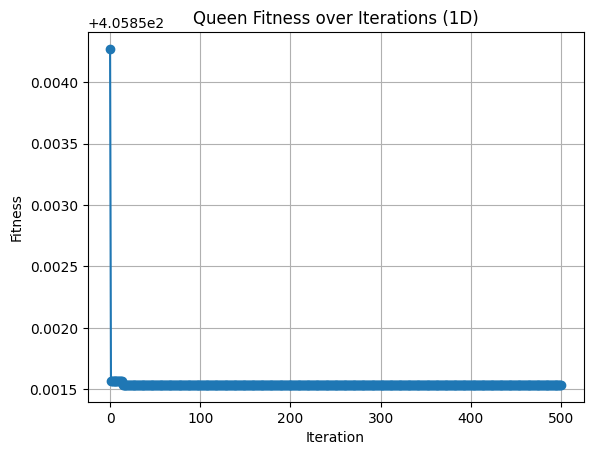

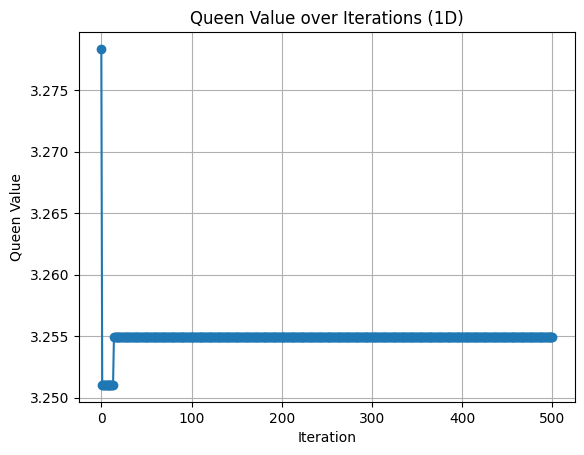

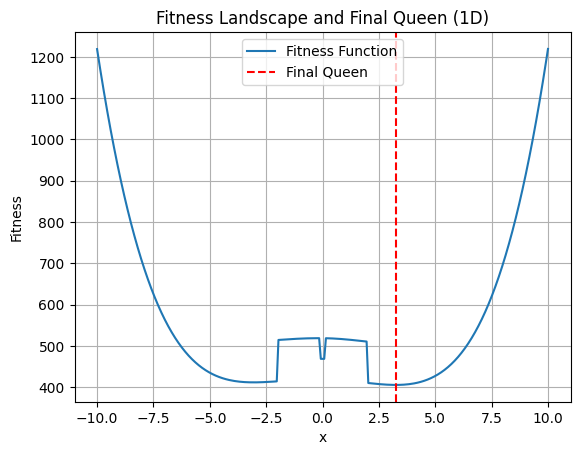

In [219]:
def visualize_1d_evolution(history, population, fitness_func, lower_bound=-20, upper_bound=10):
    # Plot queen fitness over iterations
    plt.figure()
    plt.plot(history["iteration"], history["queen_fitness"], marker='o')
    plt.title("Queen Fitness over Iterations (1D)")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness")
    plt.grid(True)
    
    # Plot queen value over iterations
    plt.figure()
    plt.plot(history["iteration"], history["queen_value"], marker='o')
    plt.title("Queen Value over Iterations (1D)")
    plt.xlabel("Iteration")
    plt.ylabel("Queen Value")
    plt.grid(True)
    
    # Plot fitness landscape and final queen value
    plt.figure()
    x_vals = np.linspace(lower_bound, upper_bound, 400)
    y_vals = [fitness_func(x) for x in x_vals]
    plt.plot(x_vals, y_vals, label="Fitness Function")
    final_queen = history["queen_value"][-1]
    plt.axvline(final_queen, color='r', linestyle='--', label="Final Queen")
    plt.title("Fitness Landscape and Final Queen (1D)")
    plt.xlabel("x")
    plt.ylabel("Fitness")
    plt.legend()
    plt.grid(True)
    
    plt.show()


visualize_1d_evolution(history, population, deceptive_function, lower_bound=-20, upper_bound=10)


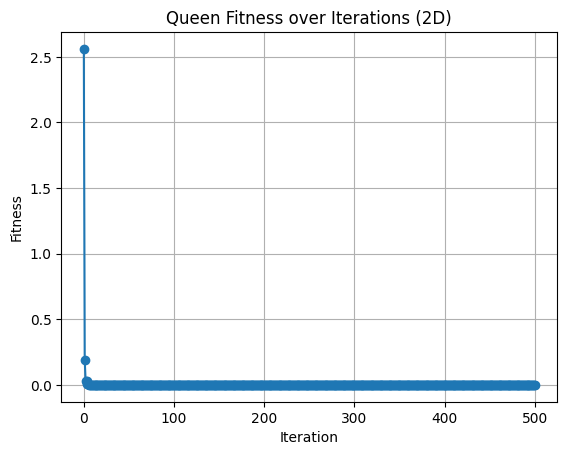

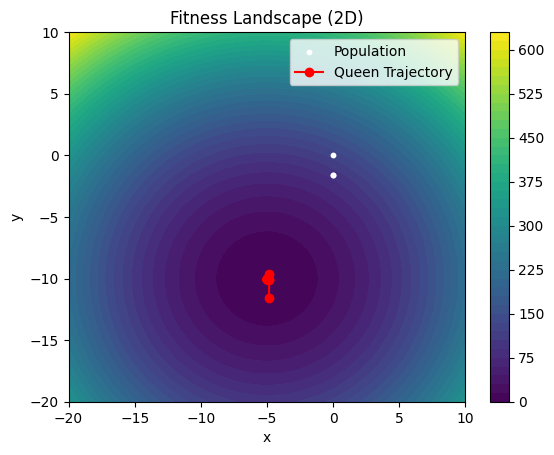

In [237]:
def visualize_2d_evolution(history, population, fitness_func, lower_bound=-20, upper_bound=10):
    # Plot queen fitness over iterations
    plt.figure()
    plt.plot(history["iteration"], history["queen_fitness"], marker='o')
    plt.title("Queen Fitness over Iterations (2D)")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness")
    plt.grid(True)
    
    # Create a contour plot of the fitness landscape
    x_range = np.linspace(lower_bound, upper_bound, 200)
    y_range = np.linspace(lower_bound, upper_bound, 200)
    X, Y = np.meshgrid(x_range, y_range)
    # Here we assume the simple_2d_circle uses the same bounds.
    Z = (X + 5)**2 + (Y + 10)**2
    plt.figure()
    cp = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(cp)
    plt.title("Fitness Landscape (2D)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(lower_bound, upper_bound)
    plt.ylim(lower_bound, upper_bound)
    
    # Overlay the final population positions
    population_points = [decode_multidim(indiv, 2) for indiv in population]
    pop_x = [point[0] for point in population_points]
    pop_y = [point[1] for point in population_points]
    plt.scatter(pop_x, pop_y, color='white', s=10, label="Population")
    
    # Plot the queen's trajectory from history
    queen_x = [q[0] for q in history["queen_value"]]
    queen_y = [q[1] for q in history["queen_value"]]
    plt.plot(queen_x, queen_y, color='red', marker='o', label="Queen Trajectory")
    plt.legend()
    
    plt.show()
    
visualize_2d_evolution(history_2d, population_2d, simple_2d_circle, lower_bound=-20, upper_bound=10)


# Logistic Regression #

Let's define the Logistic Regression class, where we can optionally choose one of the optimizer

In [249]:
import numpy as np
from typing import List, Union, Optional, Tuple, Callable

class LogisticRegression:
    def __init__(self) -> None:
        """Initialize the LogisticRegression instance with weights set to None.

        The weights are not initialized with a specific shape yet, as the input data shape
        is unknown until the fit method is called.
        """
        self.weights: Optional[np.ndarray] = None
        self.scaler = None  # Will be set during fit

    def fit(self, X: np.ndarray, y: np.ndarray, gradient_optimizer: bool = False, 
            max_iterations: int = 1000, lr: float = 0.1) -> None:
        """Fit the logistic regression model to the training data.

        Args:
            X: Input features, shape (n_samples, n_features).
            y: Target labels, shape (n_samples,).
            gradient_optimizer: If True, use gradient descent; otherwise, use evolutionary optimization.
            max_iterations: Maximum number of iterations for optimization.
            lr: Learning rate for gradient descent.

        The method scales the input features, initializes weights if necessary, and optimizes
        them using either gradient descent or an evolutionary algorithm.
        """
        from sklearn.preprocessing import StandardScaler
        # Scale the data to improve numerical stability
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        self.scaler = scaler  # Save the scaler for later use with test data

        # Initialize weights based on the training data shape if not already set
        # The +1 accounts for the bias term, which has no corresponding feature multiplier
        if self.weights is None:
            self.weights = np.random.randn(X.shape[1] + 1, 1)

        X_train = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        y = y.reshape(-1, 1)  # Ensure X_train and y are 2D arrays for shape consistency

        # Choose optimization method: gradient descent or evolutionary algorithm
        if gradient_optimizer:
            self.__gradient_optimizer(X_train, y, max_iterations=max_iterations, lr=lr)
        else:
            self.__evolutionary_optimizer(X_train, y, max_iterations=max_iterations)

    def __evolutionary_optimizer(self, X: np.ndarray, y: np.ndarray, 
                                max_iterations: int = 1000) -> dict:
        """Optimize weights using an evolutionary algorithm.

        Args:
            X: Training features with bias term, shape (n_samples, n_features + 1).
            y: Training labels, shape (n_samples, 1).
            max_iterations: Maximum number of iterations for the evolutionary process.

        Returns:
            A dictionary containing the optimization history (iterations, fitness values, solutions).

        This method calls an external evolution function, passing a fitness function that depends
        only on weights, with the training data fixed. The result updates the model weights.
        """
        final_value, history, population = evolution(
            population_size=2000,
            num_elites=100,
            num_males=100,
            crossover_size=36,
            max_iteration=max_iterations,
            fitness=self.__internal_loss_evolutionary(X, y),
            dimensions=X.shape[1],
            maximize=False
        )
        self.weights = np.array(final_value).reshape(-1, 1)
        return history

    def __gradient_optimizer(self, X: np.ndarray, y: np.ndarray, 
                            max_iterations: int = 1000, lr: float = 0.1) -> List[float]:
        """Optimize weights using gradient descent.

        Args:
            X: Training features with bias term, shape (n_samples, n_features + 1).
            y: Training labels, shape (n_samples, 1).
            max_iterations: Maximum number of iterations for gradient descent.
            lr: Learning rate for weight updates.

        Returns:
            A list of loss values recorded at each iteration.

        The method iteratively updates weights by subtracting the gradient of the loss.
        """
        losses: List[float] = []
        for _ in range(max_iterations):
            predictions = self.__predict_proba_internal(X)
            losses.append(self.loss(predictions, y))
            self.weights -= lr * (X.T @ (predictions - y))
        return losses

    def __internal_loss_evolutionary(self, X_training: np.ndarray, y_training: np.ndarray) -> Callable[[List[float]], float]:
        """Create a loss function for the evolutionary algorithm.

        Args:
            X_training: Training features with bias term, shape (n_samples, n_features + 1).
            y_training: Training labels, shape (n_samples, 1).

        Returns:
            A function that takes a list of weights and returns the loss, with training data fixed.

        This closure adapts the loss to the evolutionary algorithm's expected fitness function format.
        """
        def loss_to_optimize(list_x: List[float]) -> float:
            weights = np.array(list_x).reshape(-1, 1)
            z = np.dot(X_training, weights)
            predictions = self.__sigmoid(z)

            epsilon = 1e-10  # Small value to prevent log(0)
            predictions = np.clip(predictions, epsilon, 1.0 - epsilon)

            cost = -np.sum(y_training * np.log(predictions) + (1 - y_training) * np.log(1 - predictions))
            return cost
        return loss_to_optimize

    def __predict_proba_internal(self, x: np.ndarray) -> np.ndarray:
        """Compute probability predictions for internal use.

        Args:
            x: Input features with bias term, shape (n_samples, n_features + 1).

        Returns:
            Predicted probabilities, shape (n_samples, 1).

        This method assumes the bias term is already included in the input.
        """
        return self.__sigmoid(np.dot(x, self.weights))

    def __sigmoid(self, x: np.ndarray) -> np.ndarray:
        """Apply the sigmoid activation function.

        Args:
            x: Input array of logits, any shape compatible with numpy operations.

        Returns:
            Sigmoid-transformed values, same shape as input.

        Clips logits to prevent numerical overflow before applying the sigmoid function.
        """
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def predict(self, x: np.ndarray) -> np.ndarray:
        """Predict binary class labels.

        Args:
            x: Input features, shape (n_samples, n_features).

        Returns:
            Binary predictions (0 or 1), shape (n_samples,).
        """
        return (self.predict_proba(x) >= 0.5).astype(int)

    def predict_proba(self, x: np.ndarray) -> np.ndarray:
        """Compute probability predictions.

        Args:
            x: Input features, shape (n_samples, n_features).

        Returns:
            Predicted probabilities, shape (n_samples, 1).

        Scales the input using the stored scaler and adds the bias term before prediction.
        """
        x = self.scaler.transform(x)
        x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
        return self.__sigmoid(np.dot(x, self.weights))

    def loss(self, predictions: np.ndarray, y: np.ndarray) -> float:
        """Calculate the negative log-likelihood loss.

        Args:
            predictions: Predicted probabilities, shape (n_samples, 1).
            y: True labels, shape (n_samples, 1).

        Returns:
            The scalar loss value.
        """
        predictions = np.clip(predictions, 1e-10, 1 - 1e-10)
        return -np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))

    def get_weights(self) -> np.ndarray:
        """Retrieve a copy of the current weights.

        Returns:
            A copy of the weights array, shape (n_features + 1, 1).
        """
        return self.weights.copy()


Let's generate synthetic dataset to test our Logistic Regression class

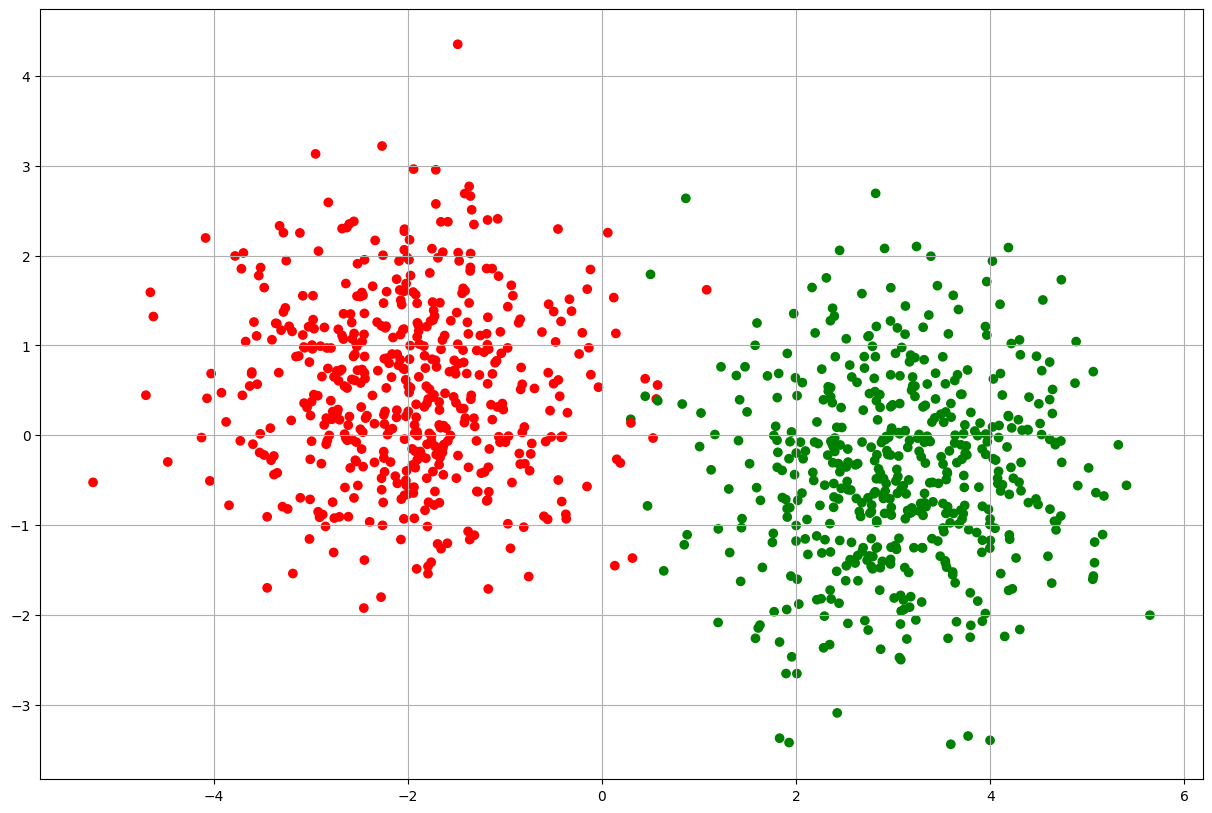

In [261]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1, random_state=42)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y.ravel() == cl] = str(colors[i])

plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.grid()
plt.show();
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Gradient-Based Optimizer ##

In [262]:
clf = LogisticRegression()
clf.fit(X_train, y_train, max_iterations=1000, gradient_optimizer=True)
w = clf.get_weights()

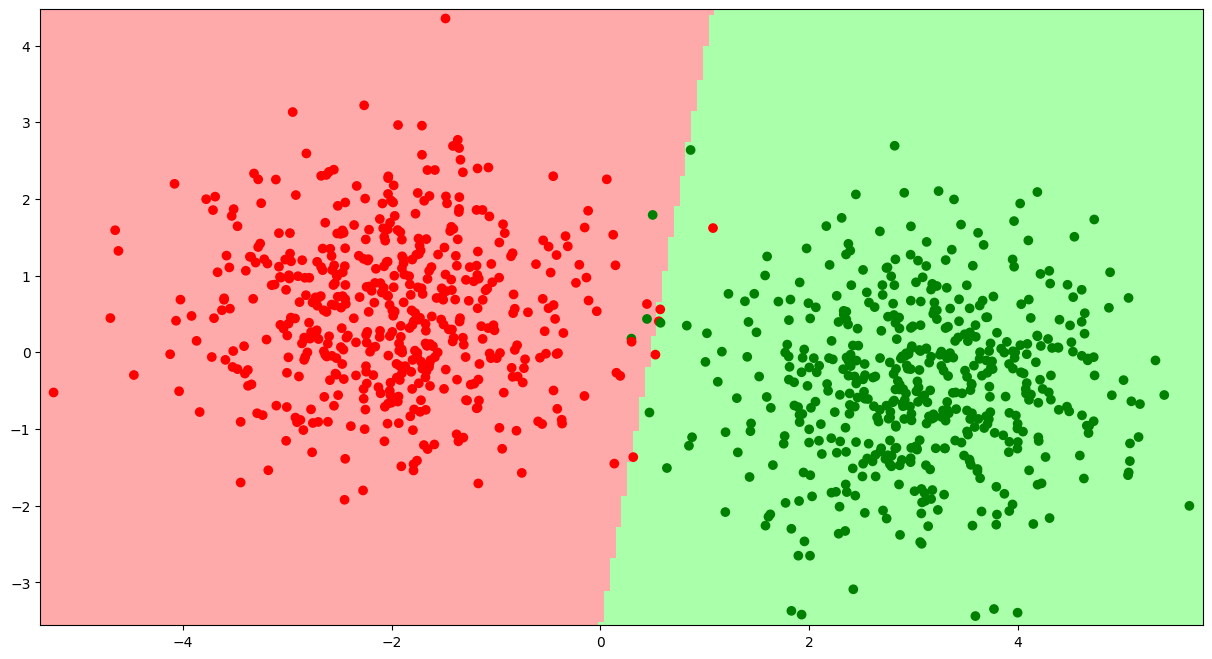

In [263]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 200),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)

In [264]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       104
           1       0.99      1.00      0.99        96

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



## Evolutionary-Based Optimizer ## 

In [266]:
clf = LogisticRegression()
clf.fit(X_train, y_train, max_iterations=100, gradient_optimizer=False)
w = clf.get_weights()

Iteration: 1, Queen: [0.01904, 63.06, -27.75], Fitness: 112.40351522029408
Iteration: 2, Queen: [0.01904, 63.06, -27.75], Fitness: 112.40351522029408
Iteration: 3, Queen: [-0.0002407, 558.5, 0.0003698], Fitness: 103.72581509636589
Iteration: 4, Queen: [-0.0002407, 558.5, 0.0003698], Fitness: 103.72581509636589
Iteration: 5, Queen: [-0.0002407, 558.5, 0.0003698], Fitness: 103.72581509636589
Iteration: 6, Queen: [0.008026, 448.5, 0.0003965], Fitness: 93.34861843507353
Iteration: 7, Queen: [0.008026, 448.5, 0.0003965], Fitness: 93.34861843507353
Iteration: 8, Queen: [0.008026, 448.5, 0.0003965], Fitness: 93.34861843507353
Iteration: 9, Queen: [0.008026, 448.5, 0.0003965], Fitness: 93.34861843507353
Iteration: 10, Queen: [0.008026, 448.5, 0.0003965], Fitness: 93.34861843507353
Iteration: 11, Queen: [0.008026, 448.5, 0.0003965], Fitness: 93.34861843507353
Iteration: 12, Queen: [0.008026, 448.5, 0.0003965], Fitness: 93.34861843507353
Iteration: 13, Queen: [0.008026, 448.5, 0.0003965], Fitnes

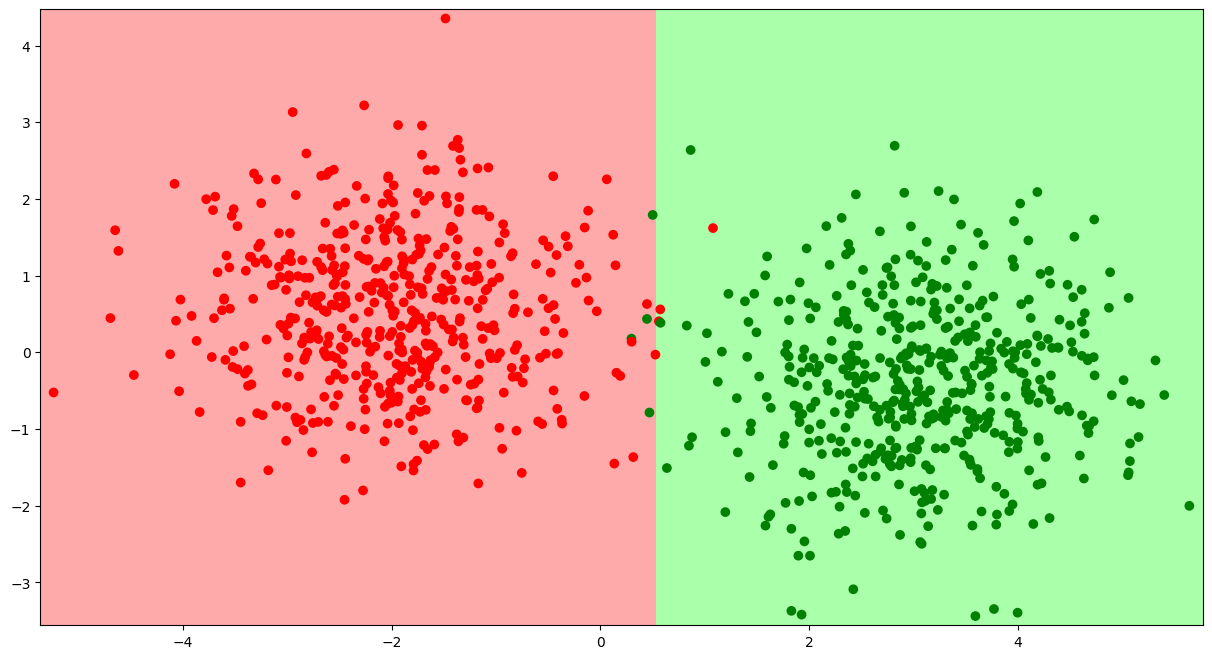

In [267]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 200),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)

In [268]:
from sklearn.metrics import classification_report

print(classification_report(y, clf.predict(X)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       500
           1       1.00      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

